In [1]:
import sys
sys.path.append('..')

In [2]:
# ckpt = '2410/Hagen-joint_indi-l1/36'
ckpt  = '2410/Hagen-joint_indi-l1/27'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
num_timesteps = 1



ckpt = ckpt.strip('/').strip(' ')
ckpt

'2410/Hagen-joint_indi-l1/27'

In [3]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [4]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
opt['datasets']['val']['datapath'] = {
 'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
 'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
 }

/group/jug/ashesh/training/diffsplit/2410/Hagen-joint_indi-l1/27/checkpoint/I850000_E2657


In [5]:
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I350000_E1094'
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I380000_E1188'
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I360000_E1125'


# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I350000_E1094'

In [6]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

In [7]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


HARDCODED upperclip to 1993. Disable it if not needed !!!
Computing mean and std for normalization
[SplitDataset] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:0.995 UpperClip:0Uncor:False InpFrmNormTar
HARDCODED upperclip to 1993. Disable it if not needed !!!
[TilingDataset] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:0.995 UpperClip:0Uncor:False InpFrmNormTar


INFO:base:Initialization method [orthogonal]


[IndiCustomT]: Sampling mode: linear_indi, Noise mode: brownian
[IndiCustomT]: Sampling mode: linear_indi, Noise mode: brownian
[JointIndi]: w_input_loss: 0.1


INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2410/Hagen-joint_indi-l1/27/checkpoint/I850000_E2657] ...
INFO:base:Model [DDPM] is created.
INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2410/Hagen-joint_indi-l1/27/checkpoint/I850000_E2657] ...


-0.4122405 1.7824968 0.05117914 0.7651223 0.023080796 1.2824968


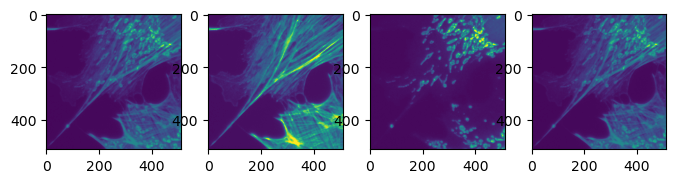

In [8]:
import matplotlib.pyplot as plt

data= train_set[0]
inp = data['input']
target = data['target']
inp = inp.transpose(1,2,0)
target = target.transpose(1,2,0)
inp = (1 + inp) / 2
target = (1 + target) / 2
is_rgb = inp.shape[-1]%3 == 0
nC = 3 if is_rgb else 1
print(inp.min(), inp.max(), target[:nC].min(), target[:nC].max(), target[nC:].min(), target[nC:].max())
_,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].imshow(inp)
ax[1].imshow(target[...,:nC])
if target.shape[-1] > nC:
    ax[2].imshow(target[...,nC:])
    ax[3].imshow((target[...,:nC] + target[...,nC:])/2)


In [9]:
import numpy as np
import random

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

norm_dict = val_set.get_normalization_dict()
nimgs = 6
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for data in dloader:
    break

diffusion_data = {'input': data['target'].mean(dim=1,keepdims=True).cuda(), 'target': data['target'].cuda()}


In [11]:
def get_prediction(data_dict):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    diffusion.feed_data(data_dict)
    diffusion.test(continous=True, clip_denoised=False)
    visuals = diffusion.get_current_visuals()
    # input, target, prediction = unnormalize_data(visuals,train_set.get_normalization_dict())
    input = visuals['input'].cpu().numpy()
    target = visuals['target'].cpu().numpy()
    prediction = visuals['prediction'].cpu().numpy()

    # unnormalize 
    pred_unnorm = prediction * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
    target_unnorm = target * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [12]:
diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')


In [13]:
img_idx = 2
tmp_data = {'input': diffusion_data['input'][img_idx:img_idx+1].cuda(), 'target': diffusion_data['target'][img_idx:img_idx+1].cuda()}
diffusion.feed_data(tmp_data)
diffusion.test(continous=True, clip_denoised=False)
visuals = diffusion.get_current_visuals()
# input, target, prediction = unnormalize_data(visuals,train_set.get_normalization_dict())
input = visuals['input'].cpu().numpy()
target = visuals['target'].cpu().numpy()
prediction = visuals['prediction'].cpu().numpy()


sampling loop time step: 100%|██████████| 1/1 [00:00<00:00, 47.48it/s]


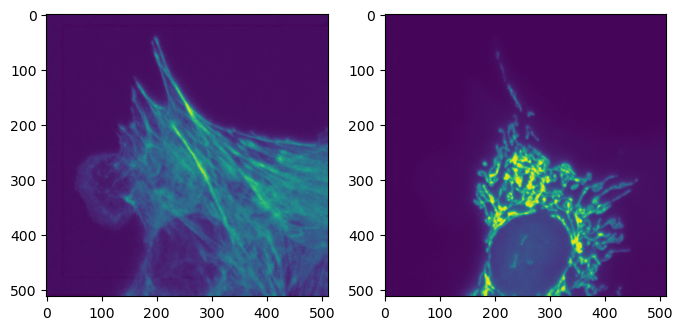

In [14]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(prediction[-1,0])
ax[1].imshow(prediction[-1,1])

In [15]:
diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')

target_arr = []
pred_arr = []
input_arr = []
for img_idx in range(nimgs):
    tmp_data = {'input':  diffusion_data['target'][img_idx:img_idx+1].mean(dim=1,keepdims=True).cuda(), 
                'target': diffusion_data['target'][img_idx:img_idx+1].cuda()}
    input_unnorm, target_unnorm, pred_unnorm = get_prediction(tmp_data)
    target_arr.append(target_unnorm)
    pred_arr.append(pred_unnorm[None])
    input_arr.append(input_unnorm)

inputs = np.concatenate(input_arr, axis=0)
targets = np.concatenate(target_arr, axis=0)
predictions = np.concatenate(pred_arr, axis=0)



sampling loop time step:   0%|          | 0/1 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


In [16]:
predictions.shape

(6, 2, 512, 512, 2)

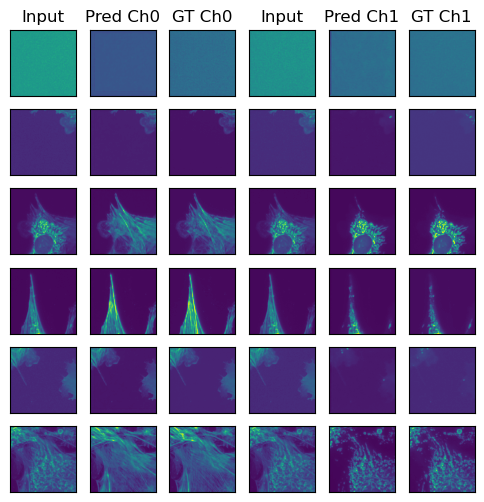

In [17]:
from disentangle.analysis.plot_utils import clean_ax
ncols = predictions.shape[1] + 1
assert nimgs % 2 == 0
nrows = 2*nimgs
dfac = 1
# rgb = target_unnorm.shape[-1]
_,ax = plt.subplots(figsize=(ncols*1*2,nrows*1//2), ncols=ncols*2, nrows=nrows//2)
ax = ax.reshape(nrows,ncols)
for img_idx in range(nimgs):
    for i in range(predictions.shape[1]):
        ax[0+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,:nC])
        ax[1+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,nC:])

    ax[0+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,:nC])
    ax[1+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,nC:])

ax[0,-1].set_title('GT Ch0')
ax[0,0].set_title('Input')
ax[0,-2].set_title('Pred Ch0')

ax[1,-1].set_title('GT Ch1')
ax[1,0].set_title('Input')
ax[1,-2].set_title('Pred Ch1')

clean_ax(ax)

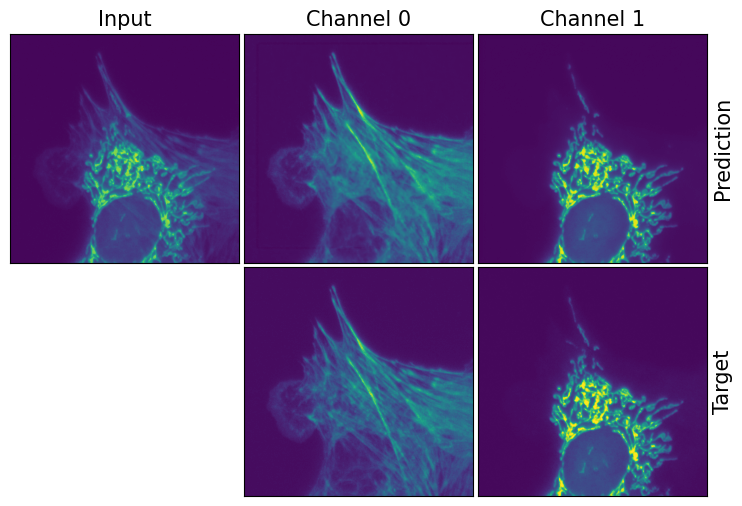

In [18]:
import matplotlib.pyplot as plt 
from disentangle.analysis.plot_utils import clean_ax
img_idx = 2
pred_tmp = predictions[img_idx,-1]
target_tmp = targets[img_idx]
input_tmp = inputs[img_idx]
rgb_ch = target_tmp.shape[-1]

_,ax = plt.subplots(figsize=(9,6),ncols=3,nrows=2)
ax[0,0].set_title('Input', fontsize=15)
ax[1,0].axis('off')



ax[0,1].set_title('Channel 0', fontsize=15)
ax[0,2].set_title('Channel 1', fontsize=15)
ax[0,2].set_ylabel('Prediction', fontsize=15)
ax[1,2].set_ylabel('Target', fontsize=15)
ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")


ax[0,0].imshow(input_tmp)
ax[0,1].imshow(pred_tmp[...,:rgb_ch//2])
ax[1,1].imshow(target_tmp[...,:rgb_ch//2])

ax[0,2].imshow(pred_tmp[...,rgb_ch//2:])
ax[1,2].imshow(target_tmp[...,rgb_ch//2:])
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

In [19]:
import seaborn as sns
show_hist = False
if show_hist:
    ncols = predictions.shape[-1]
    _,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
    for ch_idx in range(ncols):
        sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
        sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
    plt.legend()
    plt.tight_layout()

## Metrics

In [20]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm

psnr_dict = defaultdict(list)
all_predictions = []
all_targets = []
for i in tqdm(range(len(val_set))):
    data = val_set[i]
    diffusion_data = {'input': torch.Tensor(data['target'].mean(axis=0, keepdims=True))[None].cuda(), 
                      'target': torch.Tensor(data['target'][None]).cuda()
                      }
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(diffusion_data);
    all_predictions.append(pred_unnorm[-1:].astype(np.float32))
    all_targets.append(target_unnorm)
    
    ch0_psnr = torch.mean(PSNR(pred_unnorm[-1,...,:nC].transpose(2,0,1), target_unnorm[0,...,:nC].transpose(2,0,1))).item()
    ch1_psnr = torch.mean(PSNR(pred_unnorm[-1,...,nC:].transpose(2,0,1), target_unnorm[0,...,nC:].transpose(2,0,1))).item()
    psnr_dict['ch0'].append(ch0_psnr)
    psnr_dict['ch1'].append(ch1_psnr)
    

100%|██████████| 490/490 [00:30<00:00, 15.84it/s]


In [21]:
import gc; gc.collect()

83061

In [22]:
predictions = np.concatenate(all_predictions, axis=0)
predictions.shape

(490, 2, 512, 512)

In [23]:
from data.tile_stitcher import stitch_predictions
pred_stitched = stitch_predictions(predictions, val_set.tile_manager)

[10, 2048, 2048, 2]


In [24]:
max_val = None
# ch0 = np.stack(train_set._data_dict[0])
# ch1 = np.stack(train_set._data_dict[1])
# target_stitched_train = np.stack([ch0,ch1], axis=-1)
# max_val = np.quantile(target_stitched_train,0.995)


In [25]:
ch0 = np.stack(val_set._data_dict[0])
ch1 = np.stack(val_set._data_dict[1])
target_stitched = np.stack([ch0,ch1], axis=-1)
if max_val is not None:
    target_stitched[target_stitched>max_val] = max_val
    pred_stitched[pred_stitched>max_val] = max_val
target_stitched.shape

(10, 2048, 2048, 2)

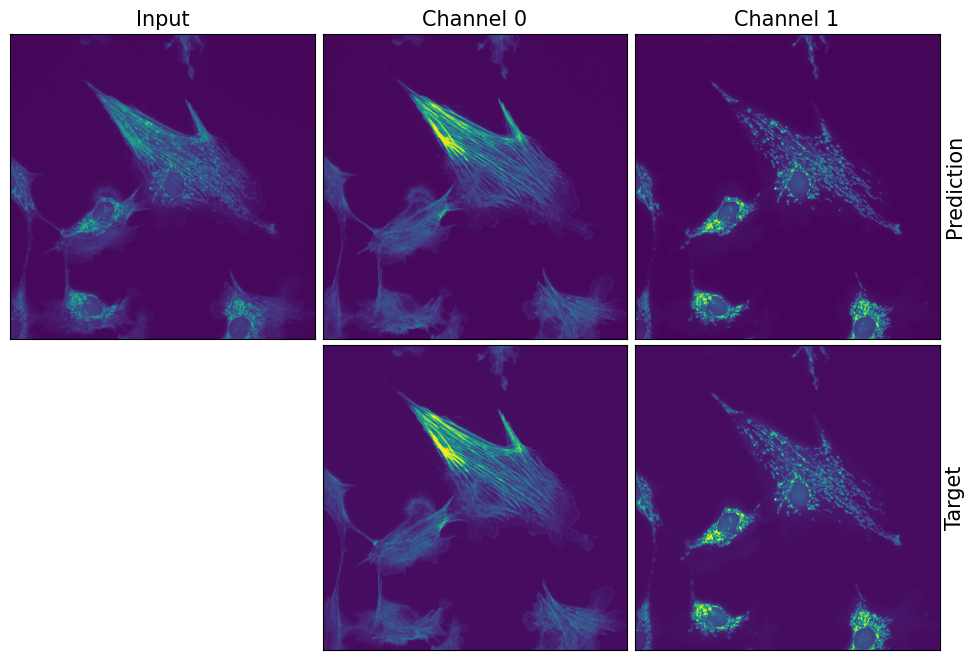

In [26]:
_,ax = plt.subplots(figsize=(12,8),ncols=3,nrows=2)
img_idx = 0
ax[0,0].imshow(target_stitched[img_idx,...,:nC] + target_stitched[img_idx,...,nC:])
ax[0,1].imshow(pred_stitched[img_idx,...,:nC])
ax[0,2].imshow(pred_stitched[img_idx,...,nC:])
ax[1,1].imshow(target_stitched[img_idx,...,:nC])
ax[1,2].imshow(target_stitched[img_idx,...,nC:])

ax[0,0].set_title('Input', fontsize=15)
ax[0,1].set_title('Channel 0', fontsize=15)
ax[0,2].set_title('Channel 1', fontsize=15)
ax[0,2].set_ylabel('Prediction', fontsize=15)
ax[1,2].set_ylabel('Target', fontsize=15)
ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")

ax[1,0].axis('off')

# reduce the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
clean_ax(ax)

In [27]:
from core.psnr import RangeInvariantPsnr
ch0psnr, ch1psnr = [RangeInvariantPsnr(target_stitched[...,i]*1.0, pred_stitched[...,i]) for i in range(2)]
msg_psnr = f'PSNR: N{num_timesteps} '
msg_psnr += f'Ch0: {ch0psnr.mean().item():.1f} +- {ch0psnr.std().item()/np.sqrt(len(ch0psnr)):.1f}\t'
msg_psnr += f'Ch1: {ch1psnr.mean().item():.1f} +- {ch1psnr.std().item()/np.sqrt(len(ch1psnr)):.1f}'
print(msg_psnr)


PSNR: N1 Ch0: 33.7 +- 0.8	Ch1: 35.9 +- 0.8


In [28]:
from collections import defaultdict
import lpips
loss_fn_vgg = lpips.LPIPS(net='alex').cuda()

def compute_lpips(target, pred):
    # NHWC -> NCHW
    target = target.transpose(0,3,1,2) # channel is  in the second dimension
    pred = pred.transpose(0,3,1,2)    
    output = defaultdict(list)
    for ch_idx in range(target.shape[1]):
        tar_tmp = target[:,ch_idx:ch_idx+1]
        pred_tmp = pred[:,ch_idx:ch_idx+1]
        tar_tmp = np.repeat(tar_tmp, 3, axis=1)
        pred_tmp = np.repeat(pred_tmp, 3, axis=1)
        max_val = tar_tmp.max()
        min_val = tar_tmp.min()
        tar_tmp  = 2*(tar_tmp - min_val)/(max_val - min_val) - 1
        pred_tmp = 2*(pred_tmp - min_val)/(max_val - min_val) - 1
        output[ch_idx] = [loss_fn_vgg(torch.Tensor(tar_tmp[i]).cuda(), torch.Tensor(pred_tmp[i]).cuda()).item() for i in range(tar_tmp.shape[0])]
    return output

lpips_dict = compute_lpips(target_stitched, pred_stitched)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [29]:
msg_lpips = f'LPIPS: N{num_timesteps} '
for k,v in lpips_dict.items():
    msg_lpips += f'Ch{k}: {np.mean(v):.3f}+-{np.std(v)/np.sqrt(len(v)):.3f}\t'

print(msg_lpips)

LPIPS: N1 Ch0: 0.038+-0.005	Ch1: 0.048+-0.006	


In [30]:
print(msg_psnr)
print(msg_lpips)

PSNR: N1 Ch0: 33.7 +- 0.8	Ch1: 35.9 +- 0.8
LPIPS: N1 Ch0: 0.038+-0.005	Ch1: 0.048+-0.006	


In [31]:
# psnr = [34.0,33.5,33.1,32.6,32.9,32.7]
# lpips = [0.042,0.037, 0.037,0.039,0.035,0.035]

psnr = [34.4,34.1,33.9,33.7, 33.9, 33.4]
lpips = [0.067,0.057, 0.050, 0.048, 0.045, 0.050]

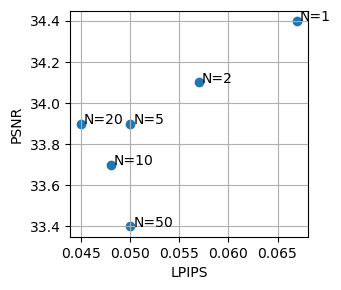

In [32]:
import matplotlib.pyplot as plt 
_,ax = plt.subplots(figsize=(3.5,3))
plt.scatter(lpips, psnr)
plt.xlabel('LPIPS')
plt.ylabel('PSNR')
# add a text for each point on the plot
text = [1,2,5,10,20,50]
for i, txt in enumerate(text):
    ax.annotate(f'N={txt}', (lpips[i]+0.0003, psnr[i]))

# ax.set_ylim(33,35)
# add grid 
plt.grid()
plt.tight_layout()

In [33]:
indi_model = diffusion.netG
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for data in dloader:
    break


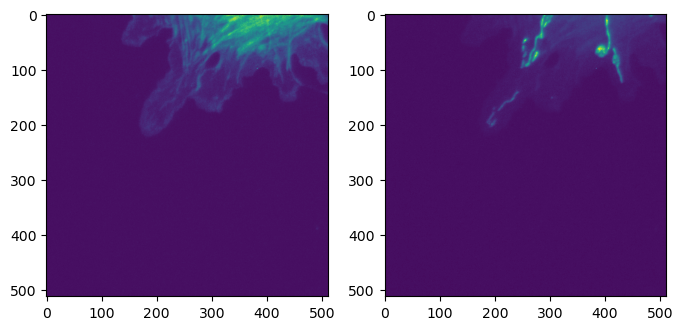

In [34]:
mixing_t = 0.15
img_idx = 1
inp_indi0 = data['target'][img_idx:img_idx+1,:1]*(1-mixing_t) + data['target'][img_idx:img_idx+1,1:2]*mixing_t
inp_indi1 = data['target'][img_idx:img_idx+1,1:2]*(1-mixing_t) + data['target'][img_idx:img_idx+1,:1]*mixing_t
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(inp_indi0[0,0].cpu())
ax[1].imshow(inp_indi1[0,0].cpu())

In [35]:
predicted_t = mixing_t

In [36]:
ch1 = indi_model.indi1.p_sample_loop(inp_indi0.cuda(), clip_denoised=True, continous=False, num_timesteps=1, t_float_start=predicted_t)
ch2 = indi_model.indi2.p_sample_loop(inp_indi1.cuda(), clip_denoised=True, continous=False, num_timesteps=1, t_float_start=predicted_t)


sampling loop time step: 100%|██████████| 1/1 [00:00<00:00, 47.88it/s]


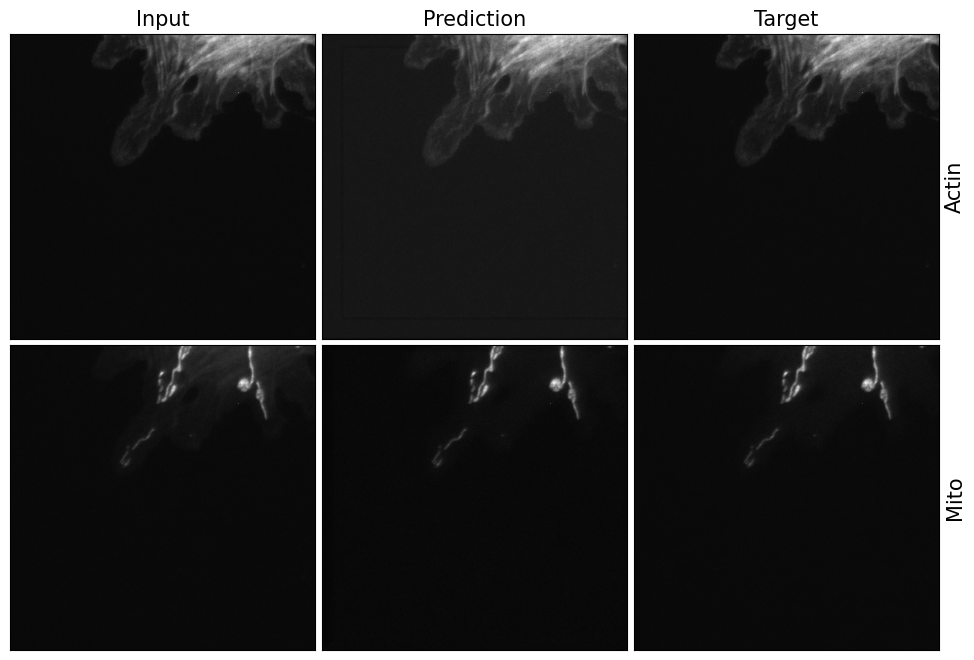

In [37]:
from disentangle.analysis.plot_utils import clean_ax

_,ax = plt.subplots(figsize=(12,8),nrows=2,ncols=3)
ax = ax.T
ax[0,0].imshow(inp_indi0[0,0], cmap='gray')
ax[0,1].imshow(inp_indi1[0,0], cmap='gray')
ax[1,0].imshow(ch1[0].cpu(), cmap='gray')
ax[1,1].imshow(ch2[0].cpu(), cmap='gray')

ax[2,0].imshow(data['target'][img_idx,0], cmap='gray')
ax[2,1].imshow(data['target'][img_idx,1], cmap='gray')
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax = ax.T
ax[0,0].set_title('Input', fontsize=15, )
ax[0,1].set_title('Prediction', fontsize=15, )
ax[0,2].set_title('Target', fontsize=15, )
ax[0,2].set_ylabel('Actin', fontsize=15, )
ax[1,2].set_ylabel('Mito', fontsize=15, )

ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")

# save the figure to file with 200 dpi
# plt.savefig(f'indi_prediction_{mixing_t}.png', dpi=200)

In [38]:
data['target'].shape

torch.Size([6, 2, 512, 512])

## Using Classifier to predict the time.

In [69]:
from model.ddpm_modules.time_predictor import TimePredictor
from data.time_predictor_dataset import compute_input_normalization_dict
input_normalization_dict = compute_input_normalization_dict(val_set._data_dict, 100, val_set._mean_target, val_set._std_target)

def normalize_indi1(inp, cur_mixing_t):
    cur_mixing_t = 1 - cur_mixing_t
    minv, maxv = input_normalization_dict[int(cur_mixing_t*100)]
    return 2*(inp - minv)/(maxv - minv) -1

def normalize_indi2(inp, cur_mixing_t):
    minv, maxv = input_normalization_dict[int(cur_mixing_t*100)]
    return 2*(inp - minv)/(maxv - minv) -1

classifier_ckpt = '/group/jug/ashesh/training/diffsplit/2410/Hagen-UnetClassifier-l2/5/'
opt = load_config(classifier_ckpt)
model_opt = opt['model']
model = TimePredictor(
    in_channel=model_opt['unet']['in_channel'],
    out_channel=model_opt['unet']['out_channel'],
    norm_groups=model_opt['unet']['norm_groups'],
    inner_channel=model_opt['unet']['inner_channel'],
    channel_mults=model_opt['unet']['channel_multiplier'],
    attn_res=model_opt['unet']['attn_res'],
    res_blocks=model_opt['unet']['res_blocks'],
    dropout=model_opt['unet']['dropout'],
    image_size=opt['datasets']['patch_size'],
    )
model = model.cuda()
# load checkpoint
model.load_state_dict(torch.load(os.path.join(classifier_ckpt,'best_time_predictor.pth')), strict=True)

# def get_time_prediction_ch0(input_ch0):
#     with torch.no_grad():
#         pred_t_0 = model(input_ch0.cuda())
#     pred_t_0 = 1 - pred_t_0
#     return pred_t_0

# def get_time_prediction_ch1(input_ch1):
#     with torch.no_grad():
#         pred_t_1 = model(input_ch1.cuda())
#     return pred_t_1

def get_inputs(data_dict, cur_mixing_t):
    inp_indi1 = data_dict['target'][:,:1] *(1-cur_mixing_t) + data_dict['target'][:,1:2]*cur_mixing_t
    inp_indi2 = data_dict['target'][:,1:2]*(1-cur_mixing_t) + data_dict['target'][:,:1] *cur_mixing_t
    return inp_indi1, inp_indi2

100%|██████████| 101/101 [00:13<00:00,  7.43it/s]


In [86]:
indi_model = diffusion.netG
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=16,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for data in dloader:
    break


In [87]:
# img_idx = 1
# _,ax = plt.subplots(figsize=(8,4),ncols=2)
# ax[0].imshow(inp_indi0[img_idx,0])
# ax[1].imshow(inp_indi1[img_idx,0])

In [93]:
mixing_t = 0.1
inp_indi1, inp_indi2 = get_inputs(data, mixing_t)
inp_indi1 = normalize_indi1(inp_indi1, mixing_t)
inp_indi2 = normalize_indi2(inp_indi2, mixing_t)

In [98]:
from core.psnr_based_t_refinement import estimate_time_using_PSNR, get_time_prediction_from_classifier
get_time_prediction_from_classifier(inp_indi2, model).median()

tensor(0.1490, device='cuda:0')

In [106]:
from core.psnr_based_t_refinement import estimate_time_using_PSNR, get_time_prediction_from_classifier
per_sample_t, aggregate_t = estimate_time_using_PSNR(inp_indi2, indi_model.indi1, indi_model.indi2, model)
print(np.mean(per_sample_t), aggregate_t)

sampling loop time step: 100%|██████████| 1/1 [00:00<00:00, 48.22it/s]


0.403125 0.4


In [104]:
per_sample_t.mean()

0.915625

In [52]:
with torch.no_grad():
    pred_t_0 = get_time_prediction_ch0(inp_indi0)
    pred_t_1 = get_time_prediction_ch1(inp_indi1)

NameError: name 'get_time_prediction_ch0' is not defined

In [159]:
pred_t_0.mean().item(), pred_t_1.mean().item()

(0.18697714805603027, 0.19091039896011353)

In [180]:
estimate_time(inp_indi0)

sampling loop time step: 100%|██████████| 1/1 [00:00<00:00, 49.15it/s]


(array([0.85, 0.95, 0.6 , 0.85, 0.95, 0.95]), 0.9500000000000001)

In [160]:
pred_ch1 = []
pred_ch2 = []
model.eval()
with torch.no_grad():
    for batch_idx in range(len(inp_indi0)):
        ch1 = indi_model.indi1.p_sample_loop(inp_indi0[batch_idx:batch_idx+1].cuda(), 
                                             clip_denoised=True, continous=False, num_timesteps=1, t_float_start=pred_t_0[batch_idx].item())
        pred_ch1.append(ch1.cpu().numpy())
        ch2 = indi_model.indi2.p_sample_loop(inp_indi1[batch_idx:batch_idx+1].cuda(), 
                                             clip_denoised=True, continous=False, num_timesteps=1, t_float_start=pred_t_1[batch_idx].item())
        pred_ch2.append(ch2.cpu().numpy())
    
    

sampling loop time step:   0%|          | 0/1 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 1/1 [00:00<00:00, 48.99it/s]


In [165]:
from disentangle.core.psnr import RangeInvariantPsnr
psnr_list = []
gt = inp_indi0.cpu().numpy()[:,0]
pred1 = np.concatenate(pred_ch1, axis=0)
pred2 = np.concatenate(pred_ch2, axis=0)
t_list = np.arange(0,1.0,0.05)
for t in t_list:
    pred = pred1*t + pred2*(1-t)
    # psnr_list.append(RangeInvariantPsnr(gt, pred).mean().item())
    psnr_list.append(RangeInvariantPsnr(gt, pred))

In [168]:
torch.argmax(torch.stack(psnr_list), dim=0)

tensor([19, 19, 18, 18, 19, 19])

0.9500000000000001 39.336265563964844


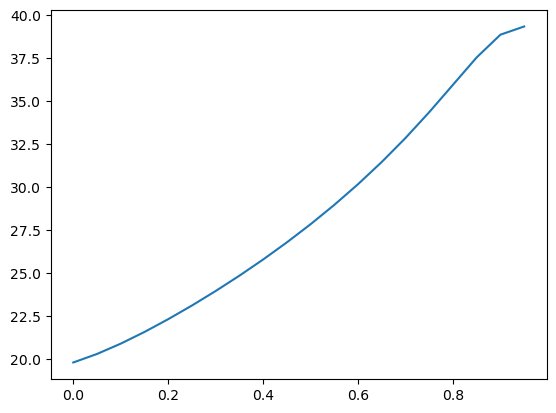

In [164]:
plt.plot(t_list, psnr_list)
idx = np.argmax(psnr_list)
print(t_list[idx], psnr_list[idx])

In [44]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

Text(0.5, 1.0, 'Mito')

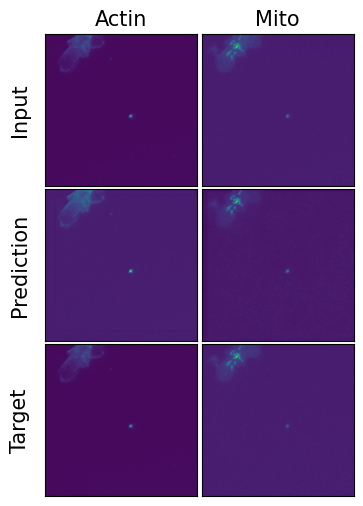

In [44]:
from disentangle.analysis.plot_utils import clean_ax
img_idx = 0

_,ax = plt.subplots(figsize=(4,6),nrows=3,ncols=2)

ax[0,0].imshow(inp_indi0[img_idx,0], )
ax[0,1].imshow(inp_indi1[img_idx,0], )
ax[1,0].imshow(pred_ch1[img_idx][0], )
ax[1,1].imshow(pred_ch2[img_idx][0], )

ax[2,0].imshow(data['target'][img_idx,0], )
ax[2,1].imshow(data['target'][img_idx,1], )
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax[0,0].set_ylabel('Input', fontsize=15, )
ax[1,0].set_ylabel('Prediction', fontsize=15, )
ax[2,0].set_ylabel('Target', fontsize=15, )
ax[0,0].set_title('Actin', fontsize=15, )
ax[0,1].set_title('Mito', fontsize=15, )

# ax[0,2].yaxis.set_label_position("right")
# ax[1,2].yaxis.set_label_position("right")

# save the figure to file with 200 dpi
# plt.savefig(f'indi_prediction_{mixing_t}.png', dpi=200)

## Qualitative Evaluation using the classifier.

In [45]:
import gc; gc.collect()

56898

In [58]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm

mixing_t_ood = 0.5
psnr_dict_ood = defaultdict(list)
mmse_count = 1
all_targets_ood = []
all_inputs_ood = []

pred_t_0_arr = []
pred_t_1_arr = []
all_mmse_predictions_ood = []
for mmse_idx in range(mmse_count):
    all_predictions_ood = []
    for i in tqdm(range(len(val_set))):
        data = val_set[i]
        inp_indi0 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
        inp_indi1 = data['target'][1:2]*(1-mixing_t_ood) + data['target'][:1]*mixing_t_ood
        all_inputs_ood.append(np.concatenate([inp_indi0, inp_indi1], axis=0)[None])
        inp_indi0 = torch.Tensor(inp_indi0[None]).cuda()
        inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
        pred_t_0 = get_time_prediction_ch0(inp_indi0.cuda()).detach().cpu().numpy() #[mixing_t_ood] #
        pred_t_1 = get_time_prediction_ch1(inp_indi1.cuda()).detach().cpu().numpy() #[mixing_t_ood] #
        pred_ch0 = indi_model.indi1.p_sample_loop(inp_indi0, clip_denoised=True, continous=False, num_timesteps=1, t_float_start=pred_t_0[0])
        pred_ch1 = indi_model.indi2.p_sample_loop(inp_indi1, clip_denoised=True, continous=False, num_timesteps=1, t_float_start=pred_t_1[0])
        pred = np.concatenate([pred_ch0.cpu().numpy(), pred_ch1.cpu().numpy()], axis=0)
        pred_unnorm = pred * norm_dict['std_target'] + norm_dict['mean_target']
        tar_unnorm = data['target'] * norm_dict['std_target'] + norm_dict['mean_target']
        if mmse_idx == 0:
            pred_t_0_arr.append(pred_t_0[0])
            pred_t_1_arr.append(pred_t_1[0])
            all_targets_ood.append(tar_unnorm[None])
        
        all_predictions_ood.append(pred_unnorm[None])

    all_predictions_ood = np.concatenate(all_predictions_ood, axis=0)
    all_mmse_predictions_ood.append(all_predictions_ood)

all_targets_ood = np.concatenate(all_targets_ood, axis=0)
all_inputs_ood = np.concatenate(all_inputs_ood, axis=0)

pred_t_0_arr = np.array(pred_t_0_arr)
pred_t_1_arr = np.array(pred_t_1_arr)


100%|██████████| 490/490 [00:44<00:00, 11.10it/s]


In [59]:
len(all_mmse_predictions_ood)

1

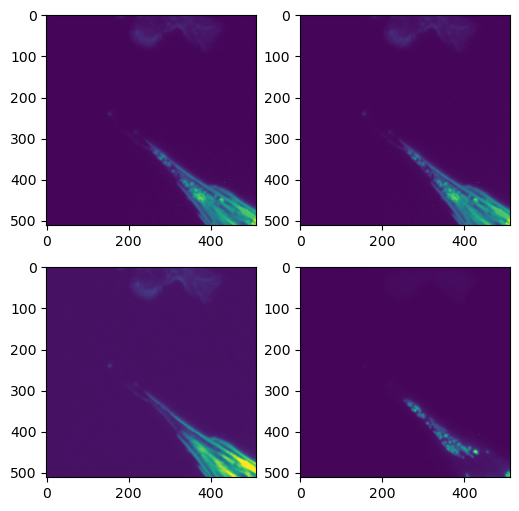

In [60]:
_,ax = plt.subplots(figsize=(6,6),nrows=2,ncols=2)
ax[0,0].imshow(all_inputs_ood[1,0])
ax[0,1].imshow(all_inputs_ood[1,1])
ax[1,0].imshow(all_predictions_ood[1,0])
ax[1,1].imshow(all_predictions_ood[1,1])

In [61]:
mmse_pred = 0 
for i in range(mmse_count):
    mmse_pred += all_mmse_predictions_ood[i]/mmse_count

In [62]:

pred_stitched_ood = stitch_predictions(mmse_pred, val_set.tile_manager)
tar_stitched_ood = stitch_predictions(all_targets_ood, val_set.tile_manager)
# inputs_stitched_ood = stitch_predictions(all_inputs_ood, val_set.tile_manager)
# target_stitched_ood = np.stack(val_set._data_dict, axis=-1)

[10, 2048, 2048, 2]
[10, 2048, 2048, 2]


In [63]:
from core.psnr import RangeInvariantPsnr
ch0psnr, ch1psnr = [RangeInvariantPsnr(tar_stitched_ood[...,i]*1.0, pred_stitched_ood[...,i]) for i in range(2)]
msg_psnr = f'W:{mixing_t_ood} M:{mmse_count} PSNR: N{num_timesteps} '
msg_psnr += f'Ch0: {ch0psnr.mean().item():.1f} +- {ch0psnr.std().item()/np.sqrt(len(ch0psnr)):.1f}\t'
msg_psnr += f'Ch1: {ch1psnr.mean().item():.1f} +- {ch1psnr.std().item()/np.sqrt(len(ch1psnr)):.1f}'
print(msg_psnr)


W:0.5 M:1 PSNR: N1 Ch0: 32.7 +- 0.9	Ch1: 34.9 +- 0.8
